In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [17]:
path = "/kaggle/input/kiemtra1/data-kiem-tra-1.csv"
data = pd.read_csv(path, encoding="latin-1")
data

,date,truong_1,truong_2,truong_3,truong_4,truong_5
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1
...,...,...,...,...,...,...
481817,03.05.2013,4,37,2437,799.00,1
481818,22.05.2013,4,37,2436,799.00,1
481819,03.05.2013,4,37,2436,799.00,1
481820,18.05.2013,4,37,2416,449.00,1


In [9]:
print("Thông tin tổng quan về dữ liệu:")
data.info()

Thông tin tổng quan về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481822 entries, 0 to 481821
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   date      481822 non-null  object 
 1   truong_1  481822 non-null  int64  
 2   truong_2  481822 non-null  int64  
 3   truong_3  481822 non-null  int64  
 4   truong_4  481822 non-null  float64
 5   truong_5  481822 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 22.1+ MB


<Axes: >

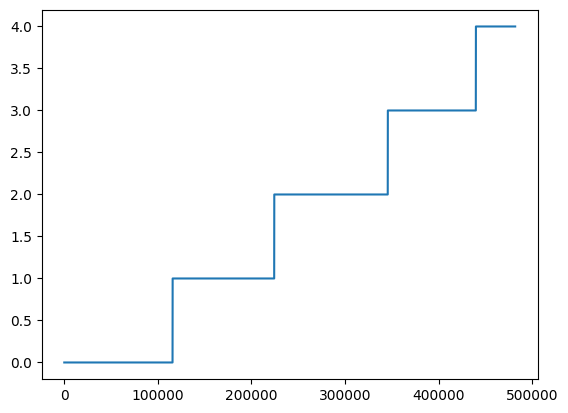

In [11]:
data['truong_1'].plot(label=f'colum {col1}')

TÌm cụm tối ưu Kmeans


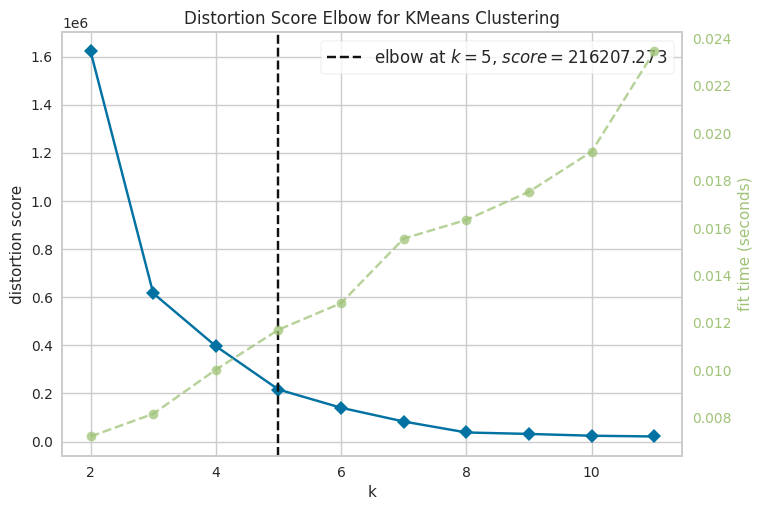

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [92]:
from yellowbrick.cluster import KElbowVisualizer
print('TÌm cụm tối ưu Kmeans')
selected_data_2d = selected_data.values
kmeans = KMeans(random_state=23, n_init=10)
Elbow_M = KElbowVisualizer(kmeans, k=(2, 12))
Elbow_M.fit(selected_data_2d)
Elbow_M.show()

In [15]:

# Chọn cột dữ liệu để dự đoán
target_column = 'truong_1'

# Lấy dữ liệu cần dự đoán
y = data[target_column].values

# Xây dựng mô hình Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)

kf = kf.em(y)

# Dự đoán giá trị tiếp theo của chuỗi thời gian
filtered_state_means, _ = kf.filter(y)
next_prediction = kf.filter_update(filtered_state_means[-1])

# Hiển thị dự đoán và dữ liệu gốc
plt.plot(y, label='Original Data')
plt.plot(filtered_state_means, label='Filtered Data')
plt.plot(len(y), next_prediction, 'ro', label='Next Prediction')
plt.legend()
plt.show()


KeyboardInterrupt: 

In [13]:
# Chọn cột dữ liệu để dự đoán
target_column = 'truong_1'

# Chọn số lượng time steps (vd: số lần quan sát liền kề trước đó)
n_steps = 10

# Tạo dữ liệu huấn luyện và kiểm tra
X = data[target_column].values
y = data[target_column].shift(-1).fillna(method='ffill').values  # Dự đoán giá trị tiếp theo

# Chuẩn bị dữ liệu theo dạng cho mạng LSTM
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X, y = prepare_data(X, n_steps)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape dữ liệu để phù hợp với input shape của mạng LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Đánh giá mô hình
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


/tmp/ipykernel_33/67417246.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = data[target_column].shift(-1).fillna(method='ffill').values  # Dự đoán giá trị tiếp theo


NameError: name 'train_test_split' is not defined